# PHAS0102 - Assignment (19002781)

In [32]:
# Importing appropirate modules
import numpy as np
import matplotlib.pylab as plt
import scipy
import numba
from numba import cuda
from time import time
from scipy.sparse import coo_matrix, linalg
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from timeit import timeit

## Part 1: Solving a wave problem with sparse matrices

In [33]:
def wave_sparse(N):
    """
    Computes a sparse matrix A and solution vector b for the time-harmonic wave problem (Ax=b).

    Input:
    N - Number of discrete points in system

    Outputs:
    A - Sparse matrix for wave problem
    b - Solution vector
    """
    
    # Creating lists for spare matrix
    rows = []
    cols = []
    data = []
    
    # Generating b vector
    b = np.zeros(N+1)
    b[N] = 1.0

    # Defining constants
    h = 1/N
    k = (29*np.pi)/2
    
    # Boundary conditions
    for i in (0,N):
      rows += [i]
      cols += [i]
      data += [1.0]

    # Wave propagation conditions
    for i in range(1,N):
      rows += [i,i,i]
      cols += [i,i+1,i-1]
      data += [2-(h**2)*(k**2),-1.0,-1.0]

    rows = np.array(rows)
    cols = np.array(cols)
    data = np.array(data)

    # Storing A as a COO sparse matrix
    A = coo_matrix((data, (rows, cols)), (N+1, N+1))
    
    return A, b


In [34]:
# List of N values to test
N = [10,100,1000]

A = []
b = []

# Calling wave_sparse function for N values
for i in N:
    A_next,b_next = wave_sparse(i)
    A.append(A_next)
    b.append(b_next)

sol = []

# Solving sparse matrix-vector problem
for i in range(len(N)):
    sol_next = linalg.spsolve(A[i],b[i])
    sol.append(sol_next)

/usr/local/lib/python3.7/dist-packages/scipy/sparse/linalg/dsolve/linsolve.py:145: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  SparseEfficiencyWarning)


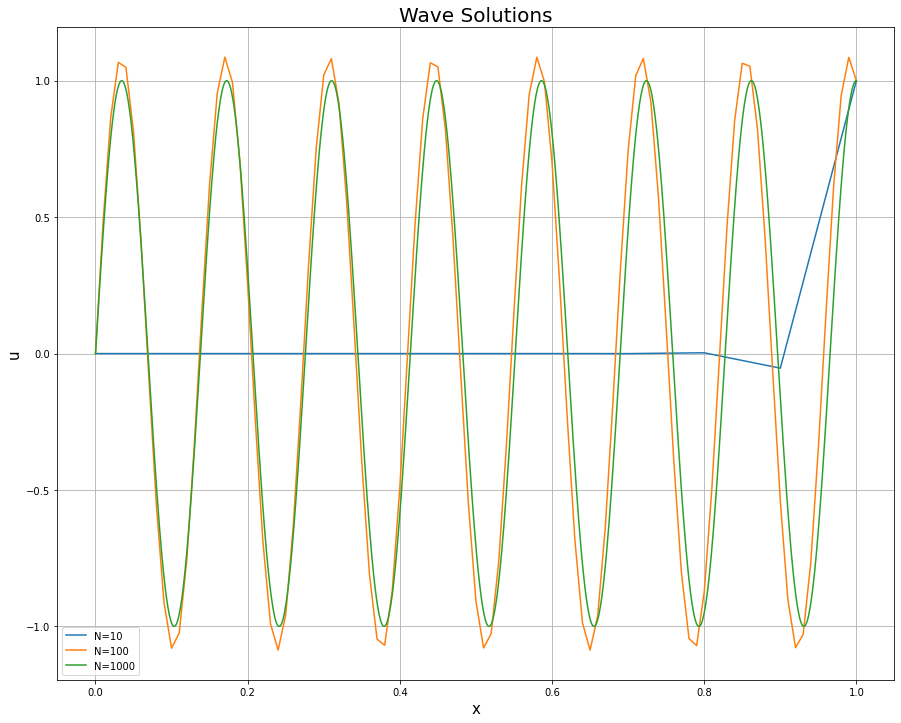

In [35]:
# Plotting wave solutions
fig = plt.figure(figsize=(15,12))

ax1 = fig.add_subplot(111)

ax1.set_title('Wave Solutions',size=20)

ax1.plot(np.linspace(0,1,N[0]+1),sol[0],label='N=10')
ax1.plot(np.linspace(0,1,N[1]+1),sol[1],label='N=100')
ax1.plot(np.linspace(0,1,N[2]+1),sol[2],label='N=1000')
ax1.set_xlabel('x',size=15)
ax1.set_ylabel('u',size=15)

ax1.grid()
ax1.legend()
plt.show()

These solutions are different as the value of N determines the number of discrete points in the system. Therefore, one would expect the largest N value (N=1000) to provide the best approximation for the system, as the spacing h=1/N closely resembles the continuous limit where h tends to zero. This can be observed here, as increasing N results in a smoother curve which approximates a sine wave.

In [36]:
def u_exact(x):
  """
  Generates a sin wave for given x-values.

  Input:
  x - Array of discrete values.

  Output:
  out - sin(k*x) function for x-values.

  """

  k = (29*np.pi)/2

  out = np.sin(k*x)

  return out

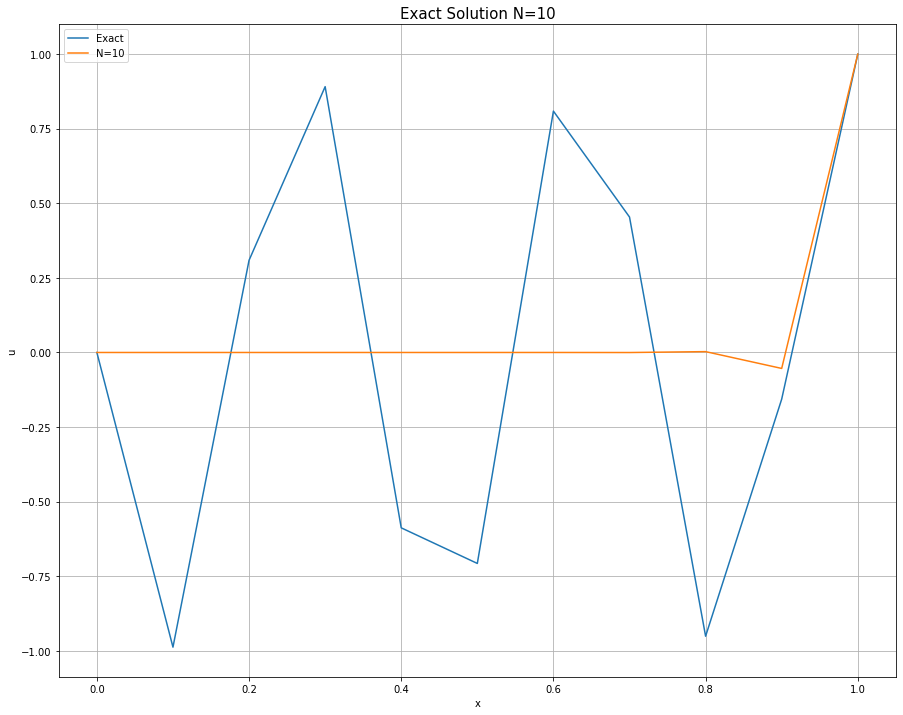

In [37]:
# Comparing exact solution to wave_sparse function result
fig2 = plt.figure(figsize=(15,12))

ax1 = fig2.add_subplot(111)

ax1.plot(np.linspace(0,1,N[0]+1),u_exact(np.linspace(0,1,N[0]+1)),label='Exact')
ax1.plot(np.linspace(0,1,N[0]+1),sol[0],label='N=10')
ax1.set_xlabel('x',size=10)
ax1.set_ylabel('u',size=10)
ax1.set_title('Exact Solution N=10',size=15)

ax1.grid()
ax1.legend()
plt.show()

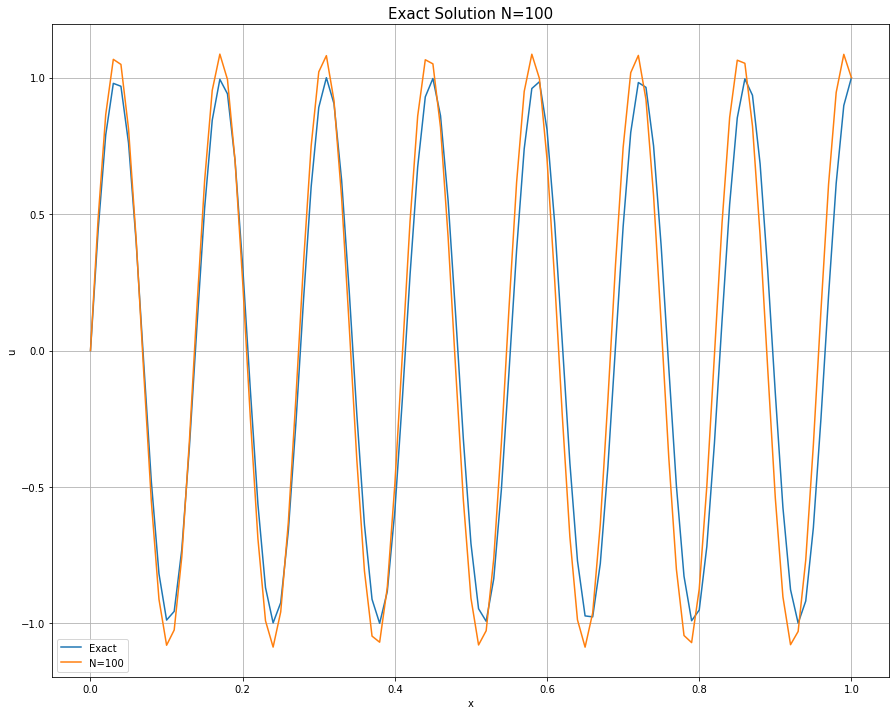

In [38]:
# Comparing exact solution to wave_sparse function result
fig3 = plt.figure(figsize=(15,12))

ax1 = fig3.add_subplot(111)

ax1.plot(np.linspace(0,1,N[1]+1),u_exact(np.linspace(0,1,N[1]+1)),label='Exact')
ax1.plot(np.linspace(0,1,N[1]+1),sol[1],label='N=100')
ax1.set_xlabel('x',size=10)
ax1.set_ylabel('u',size=10)
ax1.set_title('Exact Solution N=100',size=15)

ax1.grid()
ax1.legend()
plt.show()

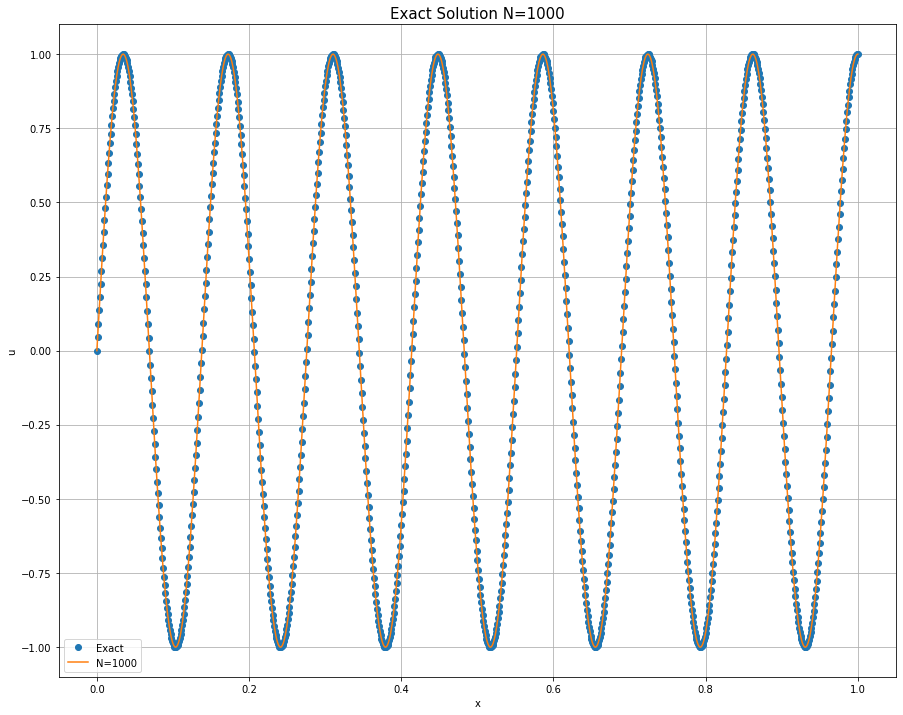

In [39]:
# Comparing exact solution to wave_sparse function result
fig4 = plt.figure(figsize=(15,12))

ax1 = fig4.add_subplot(111)

ax1.plot(np.linspace(0,1,N[2]+1),u_exact(np.linspace(0,1,N[2]+1)),'o',label='Exact')
ax1.plot(np.linspace(0,1,N[2]+1),sol[2],label='N=1000')
ax1.set_xlabel('x',size=10)
ax1.set_ylabel('u',size=10)
ax1.set_title('Exact Solution N=1000',size=15)

ax1.grid()
ax1.legend()
plt.show()

As expected, N=1000 is almost identical to the exact solution due to the small spacing (h=1/N).

In [40]:
# Array of N values to test
N = np.arange(1000,151000,1000)
k = (29*np.pi)/2

u = []

# Calling wave_sparse function for different N values
for i in N:
  A, b = wave_sparse(i)
  u.append(linalg.spsolve(A,b))

err = []

# Determining the error between exact solution and wave_sparse function
for i in u:
  err.append(np.max(abs(i - np.sin(k*np.linspace(0,1,len(i))))))

/usr/local/lib/python3.7/dist-packages/scipy/sparse/linalg/dsolve/linsolve.py:145: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  SparseEfficiencyWarning)


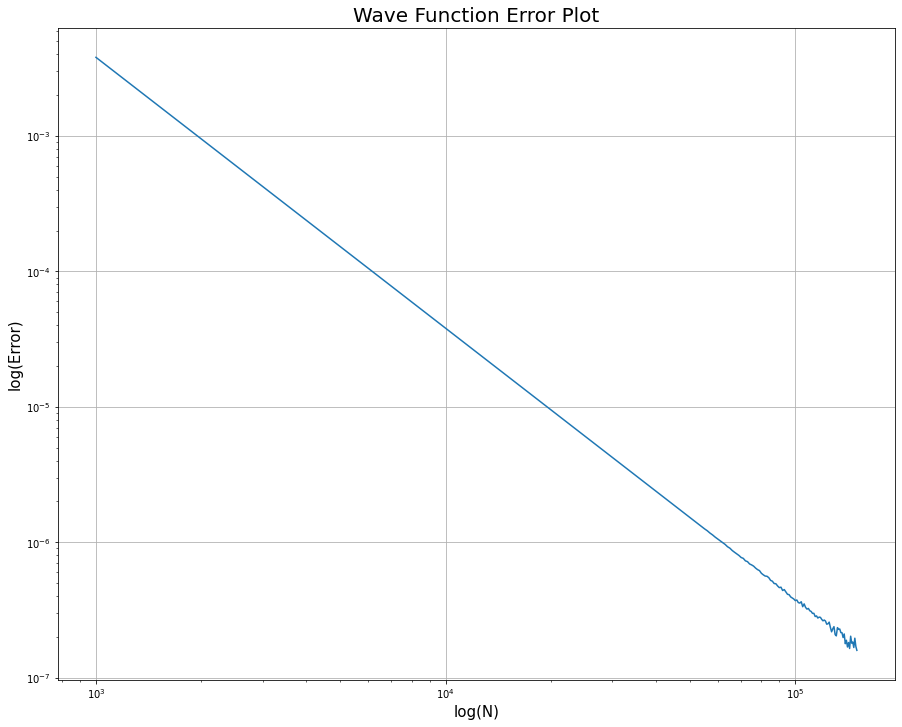

In [41]:
# Plotting log(error) for different N values
fig5 = plt.figure(figsize=(15,12))

ax1 = fig5.add_subplot(111)

ax1.plot(N,err)
ax1.set_title('Wave Function Error Plot',size=20)
ax1.set_xlabel('log(N)',size=15)
ax1.set_ylabel('log(Error)',size=15)
ax1.set_xscale("log")
ax1.set_yscale("log")


ax1.grid()
plt.show()

In [42]:
# Function to time computation
def time_function():
  linalg.spsolve(A,b)

times = []

# Timing computations
for i in N:
  A,b = wave_sparse(i)
  time_next = timeit(time_function, number=1)
  times.append(time_next)

/usr/local/lib/python3.7/dist-packages/scipy/sparse/linalg/dsolve/linsolve.py:145: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  SparseEfficiencyWarning)


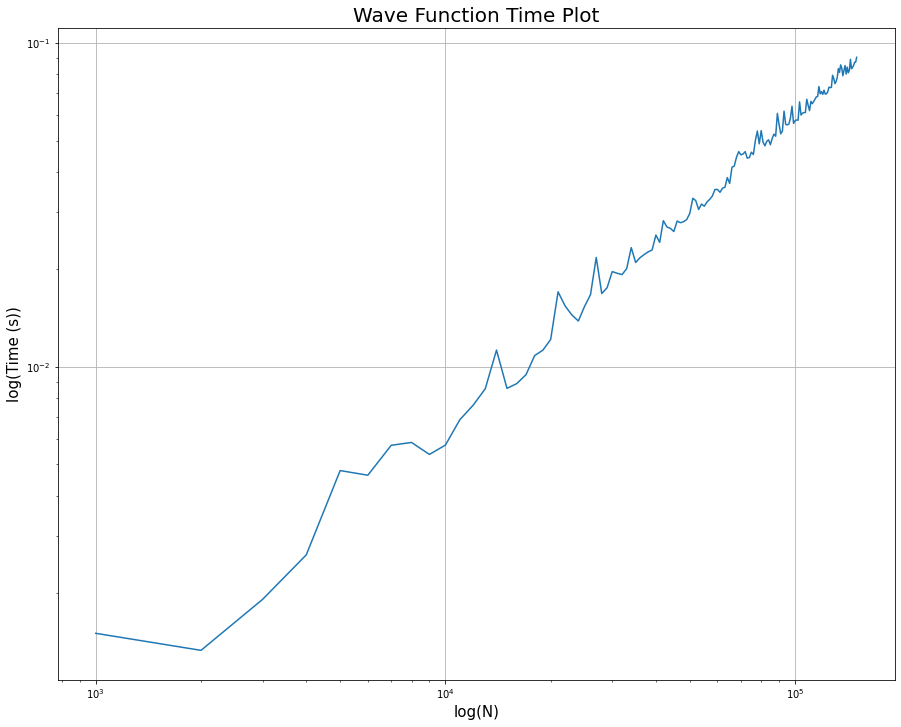

In [43]:
# Plotting run times for different N values
fig6 = plt.figure(figsize=(15,12))

ax1 = fig6.add_subplot(111)

ax1.plot(N,times)
ax1.set_title('Wave Function Time Plot',size=20)
ax1.set_xlabel('log(N)',size=15)
ax1.set_ylabel('log(Time (s))',size=15)
ax1.set_xscale("log")
ax1.set_yscale("log")


ax1.grid()
plt.show()

In [44]:
# Measuring gradient of error plot to extrapolate when the error < 1e-8
error_gradient = np.polyfit(np.log(N), np.log(err), 1)[0]
print(error_gradient)

-2.0022282551473047


In [45]:
# Estimating N using gradient of error plot
N_est = np.e**((np.log(10**(-8)) - np.log(err[0]) + error_gradient * np.log(N[0])) / error_gradient)
print(N_est)

612427.4140140448


I predicted a value of N = 612427 to obtain an error < 1e-8 by rearraging the gradient equation and using the gradient of the error plot.

In [46]:
# Measuring gradient of time plot
time_gradient = np.polyfit(np.log(N), np.log(times), 1)[0]
print(time_gradient)

0.9324549666618468


In [47]:
# Estimating time for N_est
time_est = np.e**((np.log(N_est) - np.log(N[0])) * time_gradient + np.log(times[0]))
print(time_est)

0.597168595656643


Therefore, N_est has a predicted run time of 0.60 seconds which was determined by rearranging the time plot gradient equation and using the approximate time gradient.

In [48]:
# Checking real run time and error
A,b = wave_sparse(int(N_est))
time_for_est = timeit(time_function,number=1)
u = linalg.spsolve(A,b)
error = np.max(abs(u - np.sin(k*np.linspace(0,1,len(u)))))

print(time_for_est)

/usr/local/lib/python3.7/dist-packages/scipy/sparse/linalg/dsolve/linsolve.py:145: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  SparseEfficiencyWarning)


0.43513000799998736


The real run time of N_est was 0.44.

In [49]:
print(error)

1.4806303304942814e-07


The real error for N_est was 1.48e-7.

My predicted run time of 0.60 seconds was greater than the real run time of 0.44 seconds. This may be due to the efficiency that sparse matrices offer when computing large matrix calculations. My error is also higher than the expected 1e-8 at 1.48e-7. This may be a consequence of extrapolating the error data and not taking a large enough range of N values to provide an accurate approximation for when the error is below 1e-8. As well as this, the large N value may cause the GPU to run out of memory, which could decrease the reliability of the error prediction. 

## Part 2: Solving the heat equation with GPU acceleration

In [50]:
def heated_rod(N):
  """
  Solves heat equation for 1D rod.

  Input:
  N - Number of discrete points in system.

  Output:
  u - Solution matrix of temperature values.
  """
  h = 1/N

  # Defining boundary temperature and number of iterations
  time_limit = 1000
  initial_temp = 10

  # Setting up solution matrix
  u = np.zeros((1+N*time_limit,N+1))

  # Boundary conditions
  u[:,-1] = u[:,0] = initial_temp

  # Iteration function over time period
  for i in range(N*time_limit):
    u[i+1,1:N] = u[i,1:N] + (u[i,0:N-1] - 2*u[i,1:N] + u[i,2:N+1])/(1000*h)

  return u

In [51]:
# Testing heated_rod function
N = 500
vals = heated_rod(N)

x = np.linspace(0,1,N+1)

t_1 = vals[N]
t_2 = vals[2*N]
t_10 = vals[10*N]

N = 500 was chosen in order to stop the second term in the iteration function dominating the next value ((u[i,0:N-1] - 2*u[i,1:N] + u[i,2:N+1])/(1000*h)) while still yielding an appropirate x-spacing to approximate a continuous solution. This is because a low value (N=10) would not closely resemble a continous rod while a high N value (N=1000) would award a high weighting to the second iterative term which does not appropirately update the u^(j+1) term.

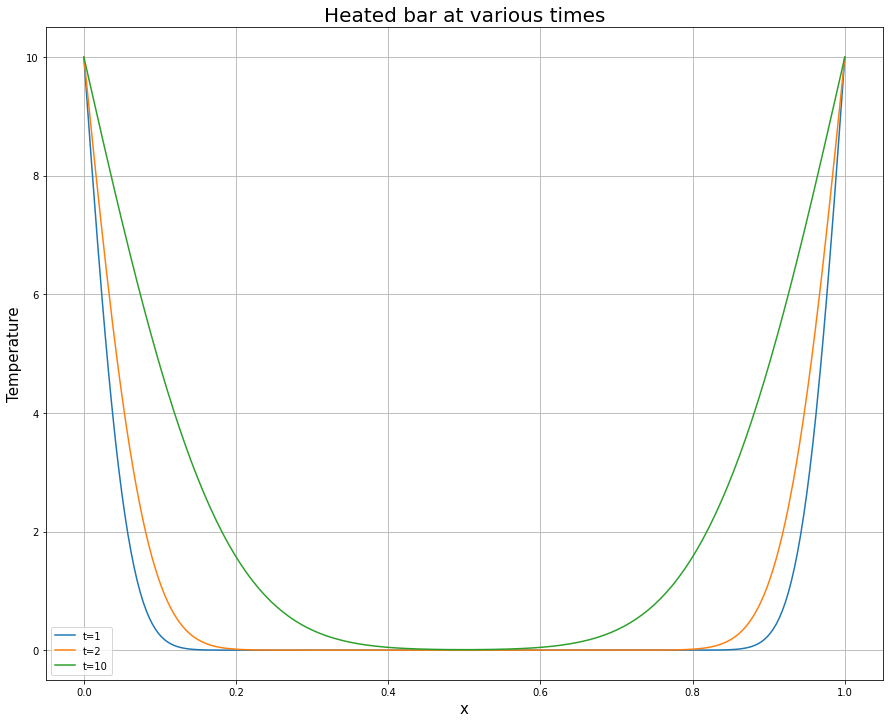

In [52]:
fig7 = plt.figure(figsize=(15,12))
ax1 = fig7.add_subplot(111)

ax1.plot(x,t_1,label='t=1')
ax1.plot(x,t_2,label='t=2')
ax1.plot(x,t_10,label='t=10')

ax1.set_title('Heated bar at various times',size=20)
ax1.set_xlabel('x',size=15)
ax1.set_ylabel('Temperature',size=15)

ax1.grid()
ax1.legend()
plt.show()

## Optimise using Cuda

In [53]:
# Checking GPU
cuda.detect()

Found 1 CUDA devices
id 0             b'Tesla T4'                              [SUPPORTED]
                      Compute Capability: 7.5
                           PCI Device ID: 4
                              PCI Bus ID: 0
                                    UUID: GPU-096b21ec-c1ec-9209-3913-6570ebbbf64a
                                Watchdog: Disabled
             FP32/FP64 Performance Ratio: 32
Summary:
	1/1 devices are supported


True

In [54]:
@cuda.jit

def heated_rod_cuda(u):
  """
  Solves heat equation for a 1D rod using GPU optimisation.

  Inputs:
  u - Input matrix 
  """
  i = cuda.grid(1)

  size = u.size - 1

  if (i>0 and i<N):
    u[i] = u[i] + (u[i+1] - 2*u[i] + u[i-1])/(1000)*size
  else:
    pass

In [55]:
# Setting up test for heated_rod_cuda function
N = 50
time_limit = 1000
u = np.zeros((N+1))
u[-1] = u[0] = 10

griddim = (128,)
blockdim = (64,)
u = cuda.to_device(u)

for j in range(N*time_limit):
  heated_rod_cuda[griddim, blockdim](u)

u = u.copy_to_host()

In [56]:
sol = heated_rod(N)

In [57]:
# Checking both heated_rod and heated_rod_cuda are equivalent for a random position
assert np.allclose(sol[-1,10], u[10])

## Determining the time that the midpoint reaches 9.8

In [61]:
# Setting up midpoint tests
N = 50
time_limit = 1000

u = np.zeros((N+1))
u[-1] = u[0] = 10
u2 = cuda.to_device(u)
mid_point = int((N/2))


griddim = (128,)
blockdim = (64,)

u_vals = []

for i in range(time_limit*N):
  heated_rod_cuda[griddim, blockdim](u2)
  u3 = u2.copy_to_host()
  u_vals.append(u3[mid_point])

In [62]:
# Determining the time where the midpoint first exceeds 9.8
time = np.argmax(np.array(u_vals) > 9.8)
real_time = time/N
print(real_time)

420.9


The time the rod's midpoint first exceeds a temperature of 9.8 is after T = 420.9.

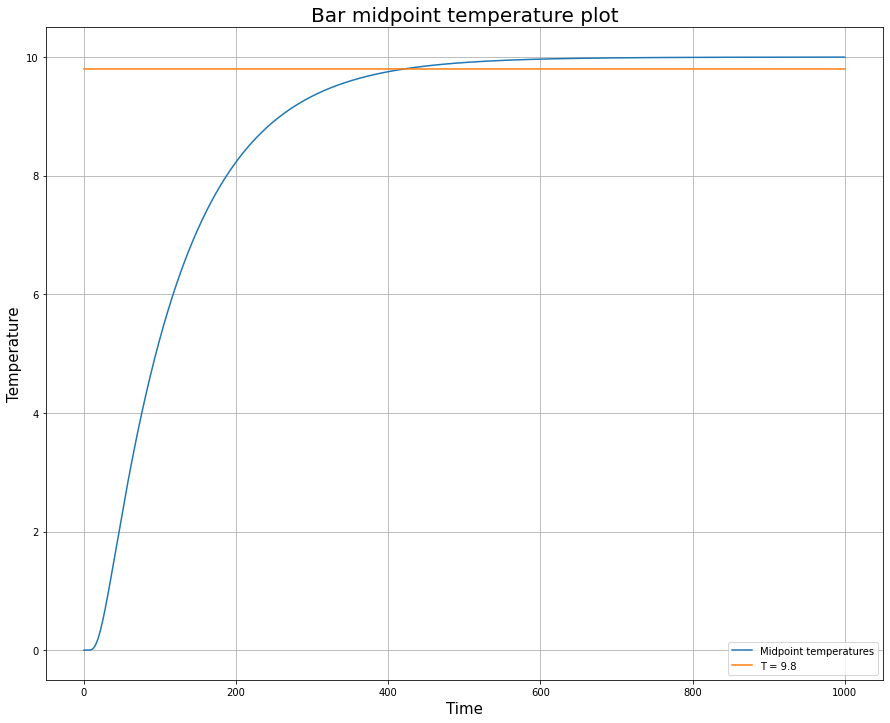

In [63]:
# Plotting rod midpoint temperature for different times to verify result
fig8 = plt.figure(figsize=(15,12))
ax1 = fig8.add_subplot(111)

ax1.plot(np.arange(0, time_limit*N, 1)/N,u_vals,label='Midpoint temperatures')
ax1.plot(np.arange(0, time_limit*N, 1)/N,9.8*np.ones(N*time_limit),label='T = 9.8')

ax1.set_title('Bar midpoint temperature plot',size=20)
ax1.set_xlabel('Time',size=15)
ax1.set_ylabel('Temperature',size=15)

ax1.legend(loc='lower right')
ax1.grid()
plt.show()

It can be seen that Time = 420.9 is a good estimation of the time when the midpoint of the rod first exceeds 9.8. This was achieved by running heated_rod_cuda for various run times and using np.argmax() to evaluate the time when the midpoint's temperature first exceeds 9.8. As well as this, a graph was plotted to support this claim graphically.